# Verify Frosty Dawgs Data Pipeline

This notebook graphs results from the Frosty Dawgs data pipeline, proccessing SWE and WRF data for one region: the Skagit region. It compares the results to data compiled from similar (but not exactly the same) data in a related project (The Prior Project).  The expectation is that the two data sources should look similar but are not expected to be identical.  

# Step 0 - Prepare the Notebook 

In [1]:
import pandas as pd
import boto3
import s3fs
import xarray as xr
import rioxarray
import matplotlib.pyplot as plt
import io
import requests
from io import StringIO
import geopandas as gpd

# Step 1 - Import to Notebook "Model Ready" Data Produced by Frosty Dawgs Pipeline

In [2]:
# def some functions to get data from S3

def s3_to_ds(bucket_name, file_name):
    s3_path = f"s3://{bucket_name}/{file_name}"
    fs = s3fs.S3FileSystem(anon=False)
    with fs.open(s3_path) as f:
        ds = xr.open_dataset(f)
        ds.load()
    return ds

def s3_to_df(file_name, bucket_name):
    """
    Loads a CSV file from an S3 bucket into a pandas DataFrame.

    Parameters:
        file_name (str): The name of the CSV file in the S3 bucket.
        bucket_name (str): The name of the S3 bucket.

    Returns:
        pd.DataFrame: A pandas DataFrame containing the data from the CSV file.
    """
    s3 = boto3.client('s3')
    response = s3.get_object(Bucket=bucket_name, Key=file_name)
    content = response['Body'].read().decode('utf-8')
    df = pd.read_csv(StringIO(content))
    return df

In [16]:
# upload the data from S3 
bucket_name = "dawgs-model-ready"
huc_id = "17110005"  
huc_lev = "Huc10" # Huc 10 as subunit of analysis  
sub_huc = '11'
full_huc = huc_id + sub_huc
print(full_huc)
#file_name = f"model_ready_{huc_lev}_in_{huc_id}.csv"
file_name = f"model_ready_huc{full_huc}.csv"
df_dawgs = s3_to_df(file_name, bucket_name)
df_dawgs.head()

1711000511


,Unnamed: 0,day,mean_swe,huc_id,mean_pr
0,0,1994-10-01,0.0,1711000511,NaN
1,1,1994-10-02,0.0,1711000511,NaN
2,2,1994-10-03,0.0,1711000511,NaN
3,3,1994-10-04,0.0,1711000511,NaN
4,4,1994-10-05,0.0,1711000511,NaN


Note no data in 0501, 0502, 0503 as they are in Canada


In [18]:
# a bit of cleaning and filtering 

# Filter to the -XX subbasin 
df_dawgs_clean = df_dawgs[df_dawgs['huc_id'] == int(full_huc)]

# Ensure the 'time' column is in datetime format
df_dawgs_clean['day'] = pd.to_datetime(df_dawgs_clean['day'])

# Filter rows where 'time' is after the year 1996
df_dawgs_clean = df_dawgs_clean[df_dawgs_clean['day'] > '1996-01-01']

# Set time as the index 
df_dawgs_clean = df_dawgs_clean.set_index('day')

# Display 
df_dawgs_clean.head()

# convert units 
df_dawgs_clean["mean_SWE"] = df_dawgs_clean["mean_swe"]/1000 # mm->m
df_dawgs_clean["mean_pr"] = df_dawgs_clean["mean_pr"]/(100**2) # TO DO: EXPLAIN UNIT CHANGE
#df_dawgs_clean["mean_tmmx"] = df_dawgs_clean["mean_tmmx"] - 273.15  # degrees K to degrees C
#df_dawgs_clean["mean_tmmn"] = df_dawgs_clean["mean_tmmn"] - 273.15  # degrees K to degrees C

col_to_kp = df_dawgs_clean.columns.drop("Unnamed: 0") 

df_dawgs_clean = df_dawgs_clean[col_to_kp]
df_dawgs_clean.head()

,mean_swe,huc_id,mean_pr,mean_SWE
day,,,,
1996-01-02,123.666664,1711000511,NaN,0.123667
1996-01-03,123.592590,1711000511,NaN,0.123593
1996-01-04,111.148150,1711000511,NaN,0.111148
1996-01-05,150.555560,1711000511,NaN,0.150556
1996-01-06,114.370370,1711000511,NaN,0.114370


Note on units.   
frosty_dawgs initial units 
 - swe is in mm H20: see https://nsidc.org/data/nsidc-0719/versions/1#anchor-documentation
 - precipitation_amount is in mm see https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_GRIDMET#bands
 - tmmx and tmmin (air_temperature) in degrees K see id
 - vs (wind speed) in m/s
 - srad (solar radiation) in W/m^2
 - rhmin and rhmax (relative humidity) in %
conversion to match Prior Project Data
- swe from mm -> m (/1000)
- air temp from K t0 C 

# Step 2 -Import to Notebook Data Used from Prior Project  

In [6]:
# mean SWE used in Prior Project collab notebook 
f = f"data_prior/wus-sr-skagit-{full_huc}-mean-swe.csv"
df_prior_swe = pd.read_csv(f)
df_prior_swe.rename(columns={'mean': 'mean_SWE'}, inplace=True)
df_prior_swe = df_prior_swe[["time", "mean_SWE"]]
df_prior_swe['time'] = pd.to_datetime(df_prior_swe['time'])
df_prior_swe = df_prior_swe[df_prior_swe['time'] >= '1996-10-01']
df_prior_swe.set_index('time', inplace=True)
print(df_prior_swe.shape)
df_prior_swe.head()


(9131, 1)


,mean_SWE
time,
1996-10-01,0.006141
1996-10-02,0.005204
1996-10-03,0.004687
1996-10-04,0.004180
1996-10-05,0.003828


In [7]:
# mean Wrf used in Prior Project collab notebook 
f = f"data_prior/wrf-skagit-{full_huc}-mean.csv"
df_prior_wrf = pd.read_csv(f)

df_prior_wrf['time'] = pd.to_datetime(df_prior_wrf['time'])

# Filter rows where 'time' is after the year 1996
df_prior_wrf = df_prior_wrf[df_prior_wrf['time'] > '1996-10-01']

#set time as index
df_prior_wrf = df_prior_wrf.set_index('time')
df_prior_wrf.head()

,spatial_ref,lw,precip,rh,sw,tair,wind
time,,,,,,,
1996-10-01 03:00:00,0,245.537154,0.0,99.956308,0.000000,1.918769,1.210923
1996-10-01 06:00:00,0,252.534000,0.0,87.618538,166.878231,3.862231,1.210923
1996-10-01 09:00:00,0,279.512154,0.0,54.057769,498.046308,11.076385,1.210923
1996-10-01 12:00:00,0,303.595462,0.0,37.019231,509.553154,17.077000,1.210923
1996-10-01 15:00:00,0,303.955615,0.0,37.343692,191.079308,17.100077,1.210923


# Plotting

In [8]:
# define plotting functions

def plot_var(df1, df2, var1, var2, time_period): 
    plt.figure(figsize=(8, 4))
    plt.plot(df1.index, df1[var1], label= "Prior Project", color='blue', linewidth=2)
    plt.plot(df2.index, df2[var2], label ='Frosty Dawgs', color='red', linewidth=2)
    

    # Add labels and title
    plt.xlabel('Time', fontsize=12)
    plt.ylabel(var1, fontsize=12)
    plt.title(f'{var1} vs. Time for {time_period} huc: {full_huc}', fontsize=14)

    # Improve plot appearance
    #plt.grid(visible=True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=10)
    plt.tight_layout()

    # Show the plot
    plt.show()
    
def plot_var_stacked(df1, df2, var1, var2, time_period):
    # Set up the figure with two subplots (vertically stacked)
    fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True, sharey=True)

    # First plot (df1)
    axes[0].plot(df1.index, df1[var1], label=f'{var1}_prior_project', color='blue', linewidth=2)
    axes[0].set_ylabel(var1, fontsize=12)
    axes[0].set_title(f"{var1} vs. Time (Collab Notebook) for {time_period} huc: {full_huc}", fontsize=14)
    axes[0].legend(fontsize=10)

    # Second plot (df2)
    # TO DO - FIX HARD CODE OF COL 
    axes[1].plot(df2.index, df2[var2], label=f'{var2} Dawgs Pipeline', color='red', linewidth=2)
    axes[1].set_xlabel('Time', fontsize=12)
    axes[1].set_ylabel(f'Mean {var2}', fontsize=12)
    axes[1].set_title(f'Mean {var2} vs. Time (Sues Pipeline) for {time_period} huc: {full_huc}', fontsize=14)
    axes[1].legend(fontsize=10)

    # Improve plot appearance
    for ax in axes:
        ax.grid(visible=True, linestyle='--', alpha=0.6)

    # Adjust layout
    plt.tight_layout()

    # Show the plot



# Plot comparing Swe Datasources

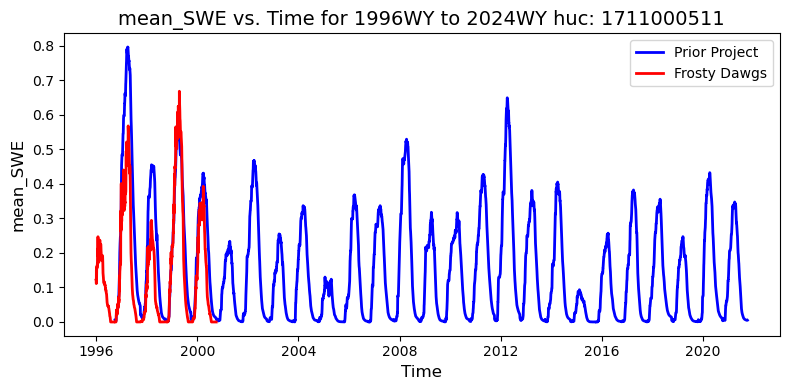

In [19]:
time_period = "1996WY to 2024WY"
var1 = "mean_SWE"
var2 = "mean_SWE"
plot_var(df_prior_swe, df_dawgs_clean, var1, var2, time_period)

In [ ]:
time_period = "1996WY to 2024WY"
var1 = "mean_SWE"
var2 = "mean_SWE"
plot_var_stacked(df_prior_swe, df_dawgs_clean, var1, var2, time_period)

# Plot Comparing Precipitation 

In [10]:
df_prior_pr = pd.DataFrame(df_prior_wrf.resample('D')['precip'].mean())
df_prior_pr.rename(columns={'precip': 'mean_pr'}, inplace=True)
df_prior_pr.head(2)

,mean_pr
time,
1996-10-01,0.000000
1996-10-02,0.000046


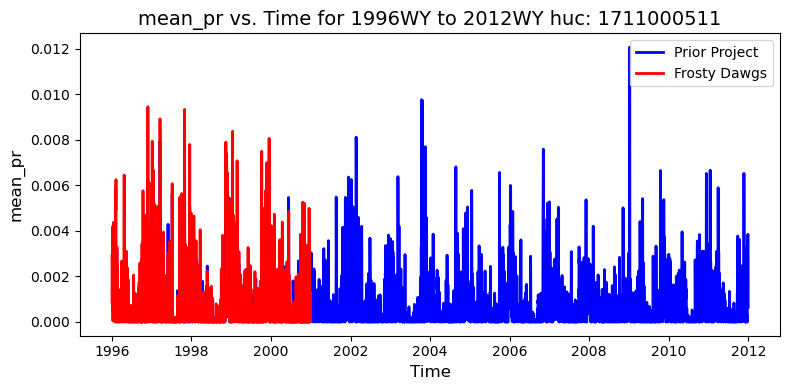

In [20]:
time_period = "1996WY to 2012WY"
var1 = "mean_pr"
var2 = "mean_pr"
plot_var(df_prior_pr, df_dawgs_clean, var1, var2,  time_period)

In [ ]:
time_period = "1996WY to 2012WY"
plot_var_stacked(df_prior_pr, df_dawgs_clean, var1, var2, time_period)

# Plot comparing cumulative precip 

In [12]:

# Definition to calculate a column for cumulative precipitation

def df_to_cumulative_pr (df, var):
    df['water_year'] = df.index.to_series().apply(lambda x: x.year + 1 if x.month >= 10 else x.year)
    # Calculate the cumulative precipitation within each water year
    df['cumulative_pr'] = df.groupby('water_year')[var].cumsum()
    return df 

In [22]:
df_dawgs_cum = df_to_cumulative_pr(df_dawgs_clean, "mean_pr")
df_dawgs_cum.head(5)


,mean_swe,huc_id,mean_pr,mean_SWE,water_year,cumulative_pr
day,,,,,,
1996-01-02,123.666664,1711000511,NaN,0.123667,1996,NaN
1996-01-03,123.592590,1711000511,NaN,0.123593,1996,NaN
1996-01-04,111.148150,1711000511,NaN,0.111148,1996,NaN
1996-01-05,150.555560,1711000511,NaN,0.150556,1996,NaN
1996-01-06,114.370370,1711000511,NaN,0.114370,1996,NaN


In [23]:
df_prior_cum = df_to_cumulative_pr(df_prior_pr, "mean_pr")
df_prior_cum.head(5)

,mean_pr,water_year,cumulative_pr
time,,,
1996-10-01,0.000000,1997,0.000000
1996-10-02,0.000046,1997,0.000046
1996-10-03,0.000417,1997,0.000463
1996-10-04,0.002790,1997,0.003254
1996-10-05,0.001459,1997,0.004713


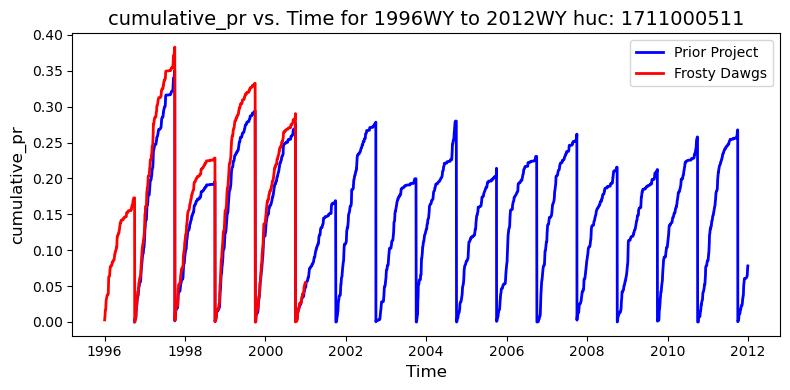

In [24]:
plot_var(df_prior_pr, df_dawgs_clean, "cumulative_pr", "cumulative_pr", time_period)

# Plot AIR TEMP

In [ ]:
df_prior_tair = pd.DataFrame(df_prior_wrf.resample('D')['tair'].mean())
df_prior_tair.head(2)


In [ ]:
var1 = "tair"
var2 = "mean_tmmx"
plot_var(df_prior_tair, df_dawgs_clean, var1, var2, time_period)

In [ ]:
var1 = "tair"
var2 = "mean_tmmn"
plot_var(df_prior_tair, df_dawgs_clean, var1, var2, time_period)

# Plot Wind

In [ ]:
df_prior_wind = pd.DataFrame(df_prior_wrf.resample('D')['wind'].mean())
df_prior_wind.head(2)

In [ ]:
var1 = "wind"
var2 = "mean_vs"
plot_var(df_prior_wind, df_dawgs_clean, var1, var2, time_period)

In [ ]:
plot_var_stacked(df_prior_wind, df_dawgs_clean, var1, var2, time_period)

# Plot Short Wave Radiation 

In [ ]:
df_prior_sr = pd.DataFrame(df_prior_wrf.resample('D')['sw'].mean())
var1 = "sw"
var2 = "mean_srad"
plot_var(df_prior_sr, df_dawgs_clean, var1, var2, time_period)

In [ ]:
plot_var_stacked(df_prior_sr, df_dawgs_clean, var1, var2, time_period)

# Plot Humidity 

In [ ]:
df_prior_rh = pd.DataFrame(df_prior_wrf.resample('D')['rh'].mean())
var1 = "rh"
var2 = "mean_rmin"
plot_var(df_prior_rh, df_dawgs_clean, var1, var2, time_period)

# Plot Skagit

In [ ]:

def s3_to_gdf(bucket_name, file_name, region_name="us-east-1"):

    s3_client = boto3.client("s3", region_name=region_name)
    
    # Download the file from S3 into a bytes buffer
    try:
        buffer = io.BytesIO()
        s3_client.download_fileobj(bucket_name, file_name, buffer)
        buffer.seek(0)  # Reset buffer position to the beginning

        # Read the file into a GeoDataFrame (assuming GeoJSON format)
        geos = gpd.read_file(buffer)

        return geos
    
    except Exception as e:
        print(f"Error downloading or reading file from S3: {e}")
        return None

In [ ]:
b = "shape-bronze"
f = "Huc10_in_17110005.geojson"
geos = s3_to_gdf(b, f)
geos

In [ ]:
geos.explore()